In [47]:
import cv2
import os
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
%matplotlib inline

In [48]:
filename = "./setgame11small.jpg" 
# filename = "./test.jpg"

In [49]:
numcards = 15
POSSIBLE_CARDS = (12, 15)

In [50]:
im = cv2.imread(filename)
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (1, 1), 1000)
flag, thresh = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY)

In [51]:
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea,reverse=True)[:numcards]  

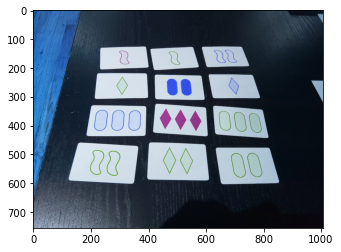

In [52]:
imgplot = plt.imshow(im)

In [53]:
def rectify(h):
    h = h.reshape((4,2))
    hnew = np.zeros((4,2),dtype = np.float32)

    add = h.sum(1)
    hnew[0] = h[np.argmin(add)]
    hnew[2] = h[np.argmax(add)]

    diff = np.diff(h,axis = 1)
    hnew[1] = h[np.argmin(diff)]
    hnew[3] = h[np.argmax(diff)]

    return hnew

In [54]:
def getMedianArea(sorted_contours, numcards):
    return np.mean([cv2.contourArea(contour) for contour in sorted_contours[:numcards]])


def filterContours(contours, medianArea, tolerance = 2.0):
    n = len(contours)
    areas = [cv2.contourArea(contour) for contour in contours]
    return [
        contours[i] for i in range(n)
        if medianArea / tolerance < areas[i] and areas[i] < medianArea * tolerance
    ]
    

In [55]:
def getCards(im, numcards=15):
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(1,1),1000)
    flag, thresh = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY) 

    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea,reverse=True)
    medianArea = getMedianArea(contours, numcards)
    contours = filterContours(contours, medianArea)
    
    n = len(contours)
    if n >= max(POSSIBLE_CARDS):
        contours = contours[:max(POSSIBLE_CARDS)]
    elif n >= min(POSSIBLE_CARDS):
        contours = contours[:min(POSSIBLE_CARDS)]
    else:
        raise ValueError("This image doesn't seem to have enough cards to play a game of set.")
        
    warpedList = []
    for card in contours:
        peri = cv2.arcLength(card,True)
        approx = rectify(cv2.approxPolyDP(card,0.02*peri,True))

        h = np.array([ [0,0],[449,0],[449,449],[0,449] ],np.float32)

        transform = cv2.getPerspectiveTransform(approx,h)
        warp = cv2.warpPerspective(im,transform,(450,450))
        warpedList.append(warp)
    return warpedList, contours


In [56]:
warped = getCards(im)

In [57]:
for i in range(len(warped)):
    cv2.imwrite('../images/examples/image_{0}.png'.format(i), warped[i])  

In [39]:
from scipy import ndimage

def filled_shape(img):
    kernel = np.ones((5,5),np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Smoothing without removing edges.
    gray_filtered = cv2.bilateralFilter(gray, 7, 50, 50)

    # Applying the canny filter
    edges_filtered = cv2.Canny(gray_filtered, 60, 120)
    mask = cv2.inRange(edges_filtered, 100, 255)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    filled = np.array(ndimage.binary_fill_holes(mask).astype(int),np.uint8)
    return filled

def num_shapes(img):
    filled = filled_shape(img)
    contours, _ = cv2.findContours(filled,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contours = [contour for contour in sorted(contours, key=cv2.contourArea,reverse=True) if cv2.contourArea(contour) < 400 **2]
    contours = filterContours(contours, cv2.contourArea(contours[0]), 2.0)
    crops = []
    for c in contours:
        # get the bounding rect
        x, y, w, h = cv2.boundingRect(c)
        # get crop
        crops.append(img[y:y+h, x:x+w])
    return len(contours), crops
    

In [46]:
i = 3
n, crops = num_shapes(warped[i])
print(n)

3


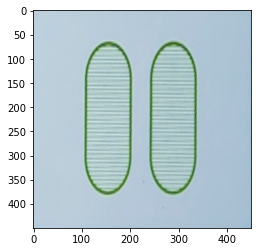

In [27]:
imgplot = plt.imshow(warped[2])

In [28]:
def get_average_nonzero_pixel(image):
    n = len(image)
    m = len(image[0])
    return np.mean([
        image[i][j]
        for i in range(n)
        for j in range(m)
        if np.sum(image[i][j]) < 3 * 250
    ], axis=0)
    
def get_color(image):
    colors = {
        "red": (0, 34, 226),
        "green": (64, 123, 0),
        "purple": (89, 0, 76)
    }
    n = len(image)
    m = len(image[0])
    avg_pixel = getAverageNonzeroPixel(image)
    diff = [
        (color, np.sum(np.abs(avg_pixel - np.array(value, dtype = "uint8"))))
        for (color, value) in colors.items()
    ]
    return min(diff, key = lambda pair: pair[1])[0]
    

In [29]:
def get_labels(image_directory="../images/"):
    labels = []
    for filename in os.listdir(image_directory):
        if filename.endswith(".png"):
            label = filename.split(".")[0].split("_")
            labels.append((filename, label))
    return labels

def predict_validate(image_directory="../images/"):
    labels = get_labels(image_directory)
    images = [(filename, cv2.imread(filename)) for (filename, _) in labels]
    
    predictions = [(filename, getColor(cv2.imread(os.path.join(image_directory, filename)))) 
                   for (filename, _) in labels]
    for i in range(len(predictions)):
        print("{} color: predicted -> {}, actual -> {}".format(
            labels[i][0], predictions[i][1], labels[i][1][3]
        ))

In [30]:
def get_color(image):
    color_masks = {
        "red": [(40, 40, 150), (120, 120, 255)],
        "green": [(34, 93, 0), (94, 153, 40)],
        "purple": [(59, 30, 46), (170, 80, 160)],
    }
    color_sums = []
    for color in color_masks.keys():
        lower, upper = color_masks[color]

        lower = np.array(lower, dtype = "uint8")
        upper = np.array(upper, dtype = "uint8")

        mask = cv2.inRange(image, lower, upper)
        color_sums.append((color, np.sum(mask)))
    return max(color_sums, key=lambda pair: pair[1])[0]
    
    

In [46]:
for i in range(len(warped)):
    print(i, filter_color(warped[i]))

0 green
1 green
2 green
3 red
4 purple
5 green
6 green
7 red
8 red
9 purple
10 green
11 red


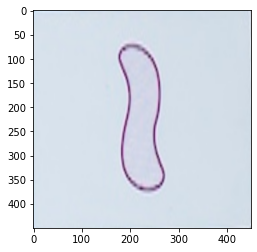

In [59]:
plt.imshow(warped[9])

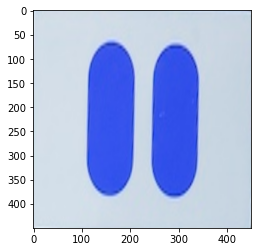

In [17]:

plt.imshow(warped[7])

In [215]:
def shape_type(img):
    
    filled = filled_shape(img)
    print(type(filled))
    filled = filled.astype(np.uint8)
    circles = cv2.HoughCircles(filled,cv2.HOUGH_GRADIENT,1, 50,
                             param1=80,param2=20,minRadius=3,maxRadius=25)
    print(circles)
    plt.imshow(filled)
    

<class 'numpy.ndarray'>
None
None


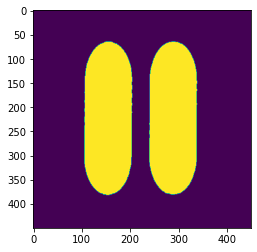

In [217]:
i = 2
print(shape_type(warped[i]))

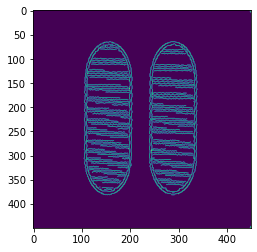

In [24]:
img = warped[2]

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


# Applying the canny filter
edges_filtered = cv2.Canny(gray, 60, 120)
plt.imshow(edges_filtered)

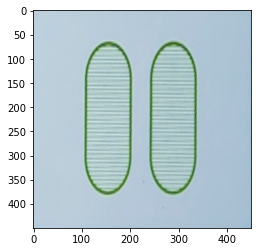

In [58]:
plt.imshow(img)